In [52]:
!pip install tqdm

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate, remove_bad_data, chi2_analysis
import pandas as pd
import numpy as np
# from tqdm import tqdm

from scipy import stats
print(pp.__version__)

import matplotlib.pyplot as plt
import ruptures as rpt

from tqdm import tqdm


2.0.1


In [2]:
def create_measurement_unit(df_measurement, net):
    list_value=[]
    list_std=[]
    for index, row in df_measurement.iterrows():
        if row['element_type'] =='bus':
            if row['meas_type'] =='v':
                mu= net.res_bus.iloc[row['element'],0]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='p':
                mu= net.res_bus.iloc[row['element'],2]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='q':
                mu= net.res_bus.iloc[row['element'],3]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
                
        elif row['element_type'] =='line':
            if row['side']=='from':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                    
                    
        elif row['element_type'] =='trafo':
            if row['side']=='from':
                if row['meas_type'] == 'v':
                    mu =net.res_trafo.iloc[row['element'],8]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'p':
                    mu =net.res_trafo.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'q':
                    mu =net.res_trafo.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='v':
                    mu =net.res_trafo.iloc[row['element'],10]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='p':
                    mu =net.res_trafo.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='q':
                    mu =net.res_trafo.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
#         print(mu)  
        value = np.random.normal(mu, sigma, 1)
        list_value.append(value[0])
        list_std.append(sigma)
    df_measurement['value']=list_value
    df_measurement['std_dev']=list_std

    for index, row in df_measurement.iterrows():
        if row['element_type']=='bus':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'])
        elif row['element_type']=='line':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'], side=row['side'])
        elif row['element_type']=='trafo':
            if row['meas_type'] in ['p','q']:
                pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                      std_dev=row['std_dev'], element=row['element'], side=row['side'])
    return df_measurement, net

In [141]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.9,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0])
scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)

In [142]:
scaling_for_solar

array([[0., 0., 0., ..., 0., 0., 0.]])

In [143]:
scaling_for_solar[0][800:804]=0.1

In [144]:
np.shape(scaling_for_solar)

(1, 1440)

In [145]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.03
lower_bus_accuracy=0.97
upper_line_accuracy=1.05
lower_line_accuracy=0.95
upper_trafo_accuracy=1.05
lower_trafo_accuracy=0.95

In [146]:
p_mw=np.array([[0,0]])
pv_location=np.random.randint(2, size=2)
# pv_location=[0,0]
print(pv_location)
for scaling_solar, load_scaling in tqdm(zip(scaling_for_solar[0],scaling_for_load[0]), total=len(scaling_for_solar[0])):
    net = pn.simple_four_bus_system()
    net.sgen.scaling=[scaling_solar*pv_location[0], scaling_solar*pv_location[1]]
    net.load.scaling=[load_scaling, load_scaling]
    pp.runpp(net)
    df_measurement=pd.DataFrame()
    df_measurement=pd.DataFrame()
    df_measurement['meas_type']=['v','v','p','p','q','q','i','i']
    df_measurement['element_type']=['bus','bus','line','line','line','line','line','line']
    df_measurement['element']=[2,3,0,1,0,1,0,1]
    df_measurement['side']=['None','None','from','from','from','from','from','from']
    df_measurement, net = create_measurement_unit(df_measurement, net)
    success = estimate(net, init="slack", calculate_voltage_angles=True, zero_injection=[1])
    new_mw=np.array([[item for item in net.res_bus_est.p_mw[2:]]])
    p_mw=np.concatenate((p_mw, new_mw), axis=0)




  0%|          | 0/1440 [00:00<?, ?it/s]

[1 1]





  0%|          | 1/1440 [00:00<07:07,  3.37it/s]


  0%|          | 2/1440 [00:00<06:48,  3.52it/s]


  0%|          | 3/1440 [00:00<06:36,  3.63it/s]


  0%|          | 4/1440 [00:01<06:29,  3.69it/s]


  0%|          | 5/1440 [00:01<06:29,  3.68it/s]


  0%|          | 6/1440 [00:01<06:35,  3.62it/s]


  0%|          | 7/1440 [00:01<06:33,  3.64it/s]


  1%|          | 8/1440 [00:02<06:37,  3.60it/s]


  1%|          | 9/1440 [00:02<06:41,  3.56it/s]


  1%|          | 10/1440 [00:02<06:31,  3.66it/s]


  1%|          | 11/1440 [00:02<06:25,  3.71it/s]


  1%|          | 12/1440 [00:03<06:17,  3.78it/s]


  1%|          | 13/1440 [00:03<06:13,  3.82it/s]


  1%|          | 14/1440 [00:03<06:12,  3.82it/s]


  1%|          | 15/1440 [00:04<06:18,  3.76it/s]


  1%|          | 16/1440 [00:04<06:16,  3.78it/s]


  1%|          | 17/1440 [00:04<06:18,  3.76it/s]


  1%|▏         | 18/1440 [00:04<06:39,  3.56it/s]


  1%|▏         | 19/1440 [00:05<06:35,  3.59it/s]


  1%|▏         | 2

  9%|▉         | 134/1440 [00:36<06:26,  3.38it/s]


  9%|▉         | 135/1440 [00:36<06:18,  3.45it/s]


  9%|▉         | 136/1440 [00:36<06:11,  3.51it/s]


 10%|▉         | 137/1440 [00:37<06:04,  3.58it/s]


 10%|▉         | 138/1440 [00:37<06:10,  3.52it/s]


 10%|▉         | 139/1440 [00:37<06:06,  3.55it/s]


 10%|▉         | 140/1440 [00:37<06:13,  3.49it/s]


 10%|▉         | 141/1440 [00:38<05:59,  3.61it/s]


 10%|▉         | 142/1440 [00:38<05:52,  3.69it/s]


 10%|▉         | 143/1440 [00:38<05:52,  3.68it/s]


 10%|█         | 144/1440 [00:39<06:05,  3.54it/s]


 10%|█         | 145/1440 [00:39<05:56,  3.63it/s]


 10%|█         | 146/1440 [00:39<06:21,  3.39it/s]


 10%|█         | 147/1440 [00:39<06:14,  3.45it/s]


 10%|█         | 148/1440 [00:40<06:14,  3.45it/s]


 10%|█         | 149/1440 [00:40<06:12,  3.46it/s]


 10%|█         | 150/1440 [00:40<06:15,  3.43it/s]


 10%|█         | 151/1440 [00:41<06:14,  3.44it/s]


 11%|█         | 152/1440 [00:41<05:58,  3.59i

 18%|█▊        | 266/1440 [01:16<05:14,  3.73it/s]


 19%|█▊        | 267/1440 [01:17<05:15,  3.71it/s]


 19%|█▊        | 268/1440 [01:17<05:18,  3.68it/s]


 19%|█▊        | 269/1440 [01:17<05:16,  3.70it/s]


 19%|█▉        | 270/1440 [01:17<05:24,  3.60it/s]


 19%|█▉        | 271/1440 [01:18<05:20,  3.64it/s]


 19%|█▉        | 272/1440 [01:18<05:18,  3.66it/s]


 19%|█▉        | 273/1440 [01:18<05:22,  3.62it/s]


 19%|█▉        | 274/1440 [01:18<05:19,  3.65it/s]


 19%|█▉        | 275/1440 [01:19<05:17,  3.66it/s]


 19%|█▉        | 276/1440 [01:19<05:21,  3.62it/s]


 19%|█▉        | 277/1440 [01:19<05:36,  3.46it/s]


 19%|█▉        | 278/1440 [01:20<05:30,  3.51it/s]


 19%|█▉        | 279/1440 [01:20<05:20,  3.62it/s]


 19%|█▉        | 280/1440 [01:20<05:27,  3.55it/s]


 20%|█▉        | 281/1440 [01:21<06:30,  2.97it/s]


 20%|█▉        | 282/1440 [01:21<06:00,  3.21it/s]


 20%|█▉        | 283/1440 [01:21<06:08,  3.14it/s]


 20%|█▉        | 284/1440 [01:22<06:00,  3.21i

 28%|██▊       | 398/1440 [01:55<04:55,  3.53it/s]


 28%|██▊       | 399/1440 [01:55<05:18,  3.27it/s]


 28%|██▊       | 400/1440 [01:55<05:05,  3.40it/s]


 28%|██▊       | 401/1440 [01:55<04:54,  3.52it/s]


 28%|██▊       | 402/1440 [01:56<05:10,  3.34it/s]


 28%|██▊       | 403/1440 [01:56<05:31,  3.13it/s]


 28%|██▊       | 404/1440 [01:56<05:29,  3.15it/s]


 28%|██▊       | 405/1440 [01:57<05:21,  3.22it/s]


 28%|██▊       | 406/1440 [01:57<05:06,  3.37it/s]


 28%|██▊       | 407/1440 [01:57<05:09,  3.33it/s]


 28%|██▊       | 408/1440 [01:58<05:09,  3.34it/s]


 28%|██▊       | 409/1440 [01:58<05:18,  3.24it/s]


 28%|██▊       | 410/1440 [01:58<05:03,  3.40it/s]


 29%|██▊       | 411/1440 [01:58<04:51,  3.53it/s]


 29%|██▊       | 412/1440 [01:59<04:43,  3.63it/s]


 29%|██▊       | 413/1440 [01:59<04:39,  3.68it/s]


 29%|██▉       | 414/1440 [01:59<04:41,  3.65it/s]


 29%|██▉       | 415/1440 [01:59<04:36,  3.70it/s]


 29%|██▉       | 416/1440 [02:00<04:32,  3.75i

 37%|███▋      | 530/1440 [02:36<04:16,  3.55it/s]


 37%|███▋      | 531/1440 [02:36<04:14,  3.57it/s]


 37%|███▋      | 532/1440 [02:37<04:12,  3.59it/s]


 37%|███▋      | 533/1440 [02:37<04:10,  3.62it/s]


 37%|███▋      | 534/1440 [02:37<04:14,  3.57it/s]


 37%|███▋      | 535/1440 [02:38<04:15,  3.54it/s]


 37%|███▋      | 536/1440 [02:38<04:14,  3.55it/s]


 37%|███▋      | 537/1440 [02:38<04:15,  3.54it/s]


 37%|███▋      | 538/1440 [02:38<04:13,  3.56it/s]


 37%|███▋      | 539/1440 [02:39<04:21,  3.45it/s]


 38%|███▊      | 540/1440 [02:39<04:31,  3.31it/s]


 38%|███▊      | 541/1440 [02:39<04:29,  3.34it/s]


 38%|███▊      | 542/1440 [02:40<04:24,  3.40it/s]


 38%|███▊      | 543/1440 [02:40<04:31,  3.30it/s]


 38%|███▊      | 544/1440 [02:40<04:30,  3.31it/s]


 38%|███▊      | 545/1440 [02:41<04:33,  3.28it/s]


 38%|███▊      | 546/1440 [02:41<04:33,  3.27it/s]


 38%|███▊      | 547/1440 [02:41<04:32,  3.28it/s]


 38%|███▊      | 548/1440 [02:42<04:44,  3.14i

 46%|████▌     | 662/1440 [03:16<03:45,  3.45it/s]


 46%|████▌     | 663/1440 [03:16<03:43,  3.48it/s]


 46%|████▌     | 664/1440 [03:17<03:40,  3.52it/s]


 46%|████▌     | 665/1440 [03:17<03:36,  3.59it/s]


 46%|████▋     | 666/1440 [03:17<03:30,  3.67it/s]


 46%|████▋     | 667/1440 [03:18<03:31,  3.65it/s]


 46%|████▋     | 668/1440 [03:18<03:49,  3.36it/s]


 46%|████▋     | 669/1440 [03:18<04:12,  3.05it/s]


 47%|████▋     | 670/1440 [03:19<04:06,  3.13it/s]


 47%|████▋     | 671/1440 [03:19<04:02,  3.16it/s]


 47%|████▋     | 672/1440 [03:19<04:06,  3.11it/s]


 47%|████▋     | 673/1440 [03:20<04:00,  3.19it/s]


 47%|████▋     | 674/1440 [03:20<04:00,  3.19it/s]


 47%|████▋     | 675/1440 [03:20<04:34,  2.78it/s]


 47%|████▋     | 676/1440 [03:21<04:30,  2.83it/s]


 47%|████▋     | 677/1440 [03:21<04:29,  2.84it/s]


 47%|████▋     | 678/1440 [03:21<04:14,  2.99it/s]


 47%|████▋     | 679/1440 [03:22<04:00,  3.17it/s]


 47%|████▋     | 680/1440 [03:22<03:57,  3.20i

 55%|█████▌    | 794/1440 [03:55<02:42,  3.98it/s]


 55%|█████▌    | 795/1440 [03:56<02:41,  3.98it/s]


 55%|█████▌    | 796/1440 [03:56<02:40,  4.02it/s]


 55%|█████▌    | 797/1440 [03:56<02:38,  4.05it/s]


 55%|█████▌    | 798/1440 [03:56<02:37,  4.07it/s]


 55%|█████▌    | 799/1440 [03:56<02:36,  4.10it/s]


 56%|█████▌    | 800/1440 [03:57<02:35,  4.11it/s]


 56%|█████▌    | 801/1440 [03:57<02:35,  4.11it/s]


 56%|█████▌    | 802/1440 [03:57<02:35,  4.11it/s]


 56%|█████▌    | 803/1440 [03:57<02:38,  4.03it/s]


 56%|█████▌    | 804/1440 [03:58<02:41,  3.95it/s]


 56%|█████▌    | 805/1440 [03:58<02:42,  3.92it/s]


 56%|█████▌    | 806/1440 [03:58<02:45,  3.84it/s]


 56%|█████▌    | 807/1440 [03:59<02:43,  3.88it/s]


 56%|█████▌    | 808/1440 [03:59<03:42,  2.84it/s]


 56%|█████▌    | 809/1440 [03:59<03:43,  2.82it/s]


 56%|█████▋    | 810/1440 [04:00<03:34,  2.93it/s]


 56%|█████▋    | 811/1440 [04:00<03:23,  3.09it/s]


 56%|█████▋    | 812/1440 [04:00<03:14,  3.23i

 64%|██████▍   | 926/1440 [04:33<02:30,  3.42it/s]


 64%|██████▍   | 927/1440 [04:34<02:24,  3.55it/s]


 64%|██████▍   | 928/1440 [04:34<02:22,  3.60it/s]


 65%|██████▍   | 929/1440 [04:34<02:21,  3.62it/s]


 65%|██████▍   | 930/1440 [04:34<02:16,  3.74it/s]


 65%|██████▍   | 931/1440 [04:35<02:12,  3.84it/s]


 65%|██████▍   | 932/1440 [04:35<02:09,  3.92it/s]


 65%|██████▍   | 933/1440 [04:35<02:07,  3.97it/s]


 65%|██████▍   | 934/1440 [04:35<02:09,  3.91it/s]


 65%|██████▍   | 935/1440 [04:36<02:12,  3.83it/s]


 65%|██████▌   | 936/1440 [04:36<02:19,  3.61it/s]


 65%|██████▌   | 937/1440 [04:36<02:22,  3.52it/s]


 65%|██████▌   | 938/1440 [04:37<02:18,  3.62it/s]


 65%|██████▌   | 939/1440 [04:37<02:16,  3.67it/s]


 65%|██████▌   | 940/1440 [04:37<02:14,  3.70it/s]


 65%|██████▌   | 941/1440 [04:37<02:14,  3.72it/s]


 65%|██████▌   | 942/1440 [04:38<02:20,  3.54it/s]


 65%|██████▌   | 943/1440 [04:38<02:23,  3.46it/s]


 66%|██████▌   | 944/1440 [04:38<02:17,  3.60i

 73%|███████▎  | 1057/1440 [05:13<02:00,  3.18it/s]


 73%|███████▎  | 1058/1440 [05:14<01:59,  3.21it/s]


 74%|███████▎  | 1059/1440 [05:14<01:56,  3.26it/s]


 74%|███████▎  | 1060/1440 [05:14<01:55,  3.28it/s]


 74%|███████▎  | 1061/1440 [05:15<01:57,  3.23it/s]


 74%|███████▍  | 1062/1440 [05:15<01:54,  3.31it/s]


 74%|███████▍  | 1063/1440 [05:15<01:50,  3.41it/s]


 74%|███████▍  | 1064/1440 [05:15<01:45,  3.55it/s]


 74%|███████▍  | 1065/1440 [05:16<01:47,  3.49it/s]


 74%|███████▍  | 1066/1440 [05:16<01:55,  3.24it/s]


 74%|███████▍  | 1067/1440 [05:16<01:57,  3.17it/s]


 74%|███████▍  | 1068/1440 [05:17<01:56,  3.19it/s]


 74%|███████▍  | 1069/1440 [05:17<01:55,  3.21it/s]


 74%|███████▍  | 1070/1440 [05:17<01:50,  3.36it/s]


 74%|███████▍  | 1071/1440 [05:17<01:50,  3.33it/s]


 74%|███████▍  | 1072/1440 [05:18<02:08,  2.85it/s]


 75%|███████▍  | 1073/1440 [05:18<02:05,  2.93it/s]


 75%|███████▍  | 1074/1440 [05:19<01:56,  3.14it/s]


 75%|███████▍  | 1075/1440 [

 82%|████████▏ | 1187/1440 [05:52<01:25,  2.96it/s]


 82%|████████▎ | 1188/1440 [05:52<01:25,  2.96it/s]


 83%|████████▎ | 1189/1440 [05:52<01:20,  3.12it/s]


 83%|████████▎ | 1190/1440 [05:53<01:20,  3.11it/s]


 83%|████████▎ | 1191/1440 [05:53<01:26,  2.88it/s]


 83%|████████▎ | 1192/1440 [05:53<01:22,  3.00it/s]


 83%|████████▎ | 1193/1440 [05:54<01:17,  3.20it/s]


 83%|████████▎ | 1194/1440 [05:54<01:13,  3.36it/s]


 83%|████████▎ | 1195/1440 [05:54<01:10,  3.45it/s]


 83%|████████▎ | 1196/1440 [05:54<01:08,  3.56it/s]


 83%|████████▎ | 1197/1440 [05:55<01:14,  3.27it/s]


 83%|████████▎ | 1198/1440 [05:55<01:19,  3.03it/s]


 83%|████████▎ | 1199/1440 [05:55<01:16,  3.13it/s]


 83%|████████▎ | 1200/1440 [05:56<01:12,  3.30it/s]


 83%|████████▎ | 1201/1440 [05:56<01:09,  3.43it/s]


 83%|████████▎ | 1202/1440 [05:56<01:20,  2.95it/s]


 84%|████████▎ | 1203/1440 [05:57<01:14,  3.20it/s]


 84%|████████▎ | 1204/1440 [05:57<01:11,  3.31it/s]


 84%|████████▎ | 1205/1440 [

 91%|█████████▏| 1317/1440 [06:32<00:35,  3.47it/s]


 92%|█████████▏| 1318/1440 [06:33<00:35,  3.49it/s]


 92%|█████████▏| 1319/1440 [06:33<00:34,  3.48it/s]


 92%|█████████▏| 1320/1440 [06:33<00:33,  3.58it/s]


 92%|█████████▏| 1321/1440 [06:33<00:32,  3.69it/s]


 92%|█████████▏| 1322/1440 [06:34<00:31,  3.78it/s]


 92%|█████████▏| 1323/1440 [06:34<00:30,  3.83it/s]


 92%|█████████▏| 1324/1440 [06:34<00:31,  3.73it/s]


 92%|█████████▏| 1325/1440 [06:35<00:31,  3.68it/s]


 92%|█████████▏| 1326/1440 [06:35<00:30,  3.74it/s]


 92%|█████████▏| 1327/1440 [06:35<00:29,  3.81it/s]


 92%|█████████▏| 1328/1440 [06:35<00:29,  3.85it/s]


 92%|█████████▏| 1329/1440 [06:36<00:28,  3.88it/s]


 92%|█████████▏| 1330/1440 [06:36<00:28,  3.89it/s]


 92%|█████████▏| 1331/1440 [06:36<00:27,  3.91it/s]


 92%|█████████▎| 1332/1440 [06:36<00:27,  3.93it/s]


 93%|█████████▎| 1333/1440 [06:37<00:29,  3.58it/s]


 93%|█████████▎| 1334/1440 [06:37<00:28,  3.67it/s]


 93%|█████████▎| 1335/1440 [

In [154]:
# find correlation
df=pd.DataFrame()
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
df['bus2']=p_mw[:,0][1:][7*60:-5*60]
df['bus3']=p_mw[:,1][1:][7*60:-5*60]

In [155]:
df['solar_irradiation'].corr(df['bus2'])

-0.8315484408288821

In [156]:
df['solar_irradiation'].corr(df['bus3'])

-0.7545057633277741

In [150]:
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]



In [151]:
df

,solar_irradiation,bus2,bus3
0,0.113094,0.012215,0.012965
1,0.109254,0.010747,0.010190
2,0.112235,0.014293,0.016161
3,0.092941,0.013144,0.013178
4,0.113093,0.013337,0.014232
5,0.107555,0.016801,0.016987
6,0.088729,0.007403,0.009030
7,0.069755,0.015015,0.015194
8,0.104218,0.016998,0.017755
9,0.103524,0.013953,0.016405


In [120]:
n_bkps = 4  # number of breakpoints
algo = rpt.Pelt(model='rbf', min_size=1, jump=5).fit(p_mw[1:])
my_bkps = algo.predict(pen=0.5)

In [121]:
my_bkps

[50,
 60,
 130,
 135,
 145,
 150,
 160,
 165,
 180,
 185,
 190,
 240,
 280,
 290,
 300,
 320,
 345,
 360,
 420,
 425,
 435,
 455,
 460,
 480,
 540,
 560,
 565,
 600,
 625,
 635,
 665,
 670,
 675,
 695,
 725,
 760,
 815,
 835,
 875,
 900,
 920,
 1010,
 1020,
 1075,
 1080,
 1085,
 1100,
 1105,
 1140,
 1210,
 1230,
 1235,
 1260,
 1270,
 1290,
 1320,
 1380,
 1440]

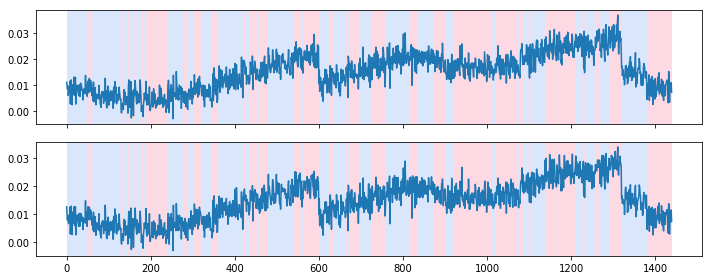

In [122]:
# display
rpt.display(p_mw[1:], my_bkps)
plt.show()

In [125]:
p_mw[:,0][1:][100:200]

array([ 0.00569272,  0.00230209,  0.00720292,  0.00390259,  0.00433561,
        0.0077766 ,  0.00414279,  0.00573503,  0.00761586,  0.00421141,
        0.0075715 ,  0.00107135,  0.00922682,  0.00817331,  0.00321124,
        0.01133035,  0.00754979,  0.00693254,  0.0092814 ,  0.0028281 ,
        0.00604866,  0.00642862,  0.00398196,  0.00435054,  0.00533673,
        0.00923647,  0.00724695,  0.00582147,  0.00428279,  0.00461364,
       -0.00052525, -0.00067846,  0.00172366,  0.00304917,  0.00135562,
        0.00063581,  0.00626403,  0.0082861 ,  0.00466116,  0.00729819,
        0.00239275,  0.00536201,  0.00322601,  0.00267441,  0.00559719,
        0.00480281, -0.00079597,  0.00899233,  0.01199352,  0.00883569,
        0.0016865 ,  0.00136739,  0.00230905,  0.01133645, -0.00261595,
        0.00326747,  0.00222291,  0.00765189,  0.00751038, -0.00177844,
        0.00830268,  0.00581668,  0.00645016,  0.01173653,  0.0089106 ,
        0.00711523,  0.00380488,  0.00276105,  0.00757932,  0.00